In [1]:
%matplotlib inline
# %matplotlib notebook
import h5py
import rasterio
import rasterio.plot 
# from rasterio.plot import show
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd
import numpy as np
import cv2
import os
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

In [2]:
def get_gaussian_kernel(fs_x, fs_y, sigma):
    """
    Create a 2D gaussian kernel
    :param fs_x: filter width along x axis
    :param fs_y: filter width along y axis
    :param sigma: gaussian width
    :return: 2D Gaussian filter of [fs_y x fs_x] dimension
    """
    gaussian_kernel_x = cv2.getGaussianKernel(ksize=np.int(fs_x), sigma=sigma)
    gaussian_kernel_y = cv2.getGaussianKernel(ksize=np.int(fs_y), sigma=sigma)
    gaussian_kernel = gaussian_kernel_y * gaussian_kernel_x.T
    return gaussian_kernel

In [3]:
def get_density_map_gaussian(points, d_map_h, d_map_w, sigma = 4):
    """
    Creates density maps from ground truth point locations
    :param points: [x,y] x: along width, y: along height
    :param d_map_h: height of the density map
    :param d_map_w: width of the density map
    :return: density map
    """

    im_density = np.zeros(shape=(d_map_h,d_map_w), dtype=np.float32)

    if np.shape(points)[0] == 0:
        sys.exit()
    for i in range(np.shape(points)[0]):

        f_sz = 15
#         sigma = 4

        gaussian_kernel = get_gaussian_kernel(f_sz, f_sz, sigma)

        x = min(d_map_w, max(1, np.abs(np.int32(np.floor(points[i][0])))))
        y = min(d_map_h, max(1, np.abs(np.int32(np.floor(points[i][1])))))

        if(x > d_map_w or y > d_map_h):
            continue

        x1 = x - np.int32(np.floor(f_sz / 2))
        y1 = y - np.int32(np.floor(f_sz / 2))
        x2 = x + np.int32(np.floor(f_sz / 2))
        y2 = y + np.int32(np.floor(f_sz / 2))

        dfx1 = 0
        dfy1 = 0
        dfx2 = 0
        dfy2 = 0

        change_H = False

        if(x1 < 1):
            dfx1 = np.abs(x1)+1
            x1 = 1
            change_H = True

        if(y1 < 1):
            dfy1 = np.abs(y1)+1
            y1 = 1
            change_H = True

        if(x2 > d_map_w):
            dfx2 = x2 - d_map_w
            x2 = d_map_w
            change_H = True

        if(y2 > d_map_h):
            dfy2 = y2 - d_map_h
            y2 = d_map_h
            change_H = True

        x1h = 1+dfx1
        y1h = 1+dfy1
        x2h = f_sz - dfx2
        y2h = f_sz - dfy2

        if (change_H == True):
            f_sz_y = np.double(y2h - y1h + 1)
            f_sz_x = np.double(x2h - x1h + 1)

            gaussian_kernel = get_gaussian_kernel(f_sz_x, f_sz_y, sigma)

        im_density[y1-1:y2,x1-1:x2] = im_density[y1-1:y2,x1-1:x2] +  gaussian_kernel
    return im_density

In [4]:
def get_coordenadas(raster,puntos,url_salida,nombre):
    pixeles = pd.DataFrame(columns=['x', 'y'])
    for index in range(puntos.shape[0]):
        pl = raster.index(puntos["geometry"][index].bounds[0],puntos["geometry"][index].bounds[1])
        pixeles.loc[index] = [pl[0],pl[1]]
    
    pixeles.to_csv(url_salida+"/"+nombre+".csv")
    return pixeles
        

In [9]:
# linux = '/media/daniel/Respaldo/Memoria/Codigo Memoria/'
windows = 'D:/Memoria/Codigo Memoria/'
url_imagen = windows + 'CONTEO_SATELITE/imagenes/corte_pequeño.tif'
# corte = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/corte_pequeño.shp'
# shp = windows + 'CONTEO_SATELITE/puntos_arboles/40050_pira_2017_arb.shp'
# rotados = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/puntos_rotados/puntos_rotados.shp'
rotados = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/puntos_cortados.shp'
# url_salida = "/home/diego/Proyecto Vivero/train2"
# url_imagen = 'D:/Memoria/Codigo/AraucoNursery/PROYECTOS/VIVERO/imagenes/rotado_cortado.tif'
# shp = 'D:/Memoria/Codigo/AraucoNursery/PROYECTOS/VIVERO/puntos_rotados/test.shp'
url_salida = "D:/Memoria/Codigo Memoria/train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = "D:/Memoria/Codigo Memoria/train/"+str(datetime.datetime.now().day)+"/png/"
url_salida_tiff = "D:/Memoria/Codigo Memoria/train/"+str(datetime.datetime.now().day)+"/tiff/"
url_salida_shp = "D:/Memoria/Codigo Memoria/train/"+str(datetime.datetime.now().day)+"/shp/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'

In [7]:
if not os.path.exists(url_salida):
    os.makedirs(url_salida)
if not os.path.exists(url_salida_png):
    os.makedirs(url_salida_png)
if not os.path.exists(url_salida_tiff):
    os.makedirs(url_salida_tiff)
if not os.path.exists(url_salida_shp):
    os.makedirs(url_salida_shp)

In [10]:
# puntos = gpd.read_file(shp)
puntos = gpd.read_file(rotados)
raster = rasterio.open(url_imagen)

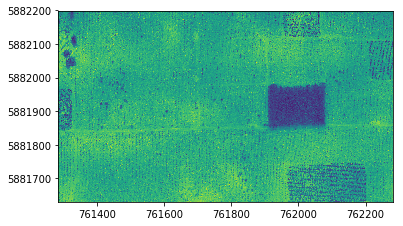

In [11]:
rasterio.plot.show(raster)

In [9]:
# puntos = gpd.read_file(shp)
# 761.774,565  5.881.886,945 Meters

In [10]:
# puntos = puntos.rotate(48.01,origin=(761774.565,5881886.945))

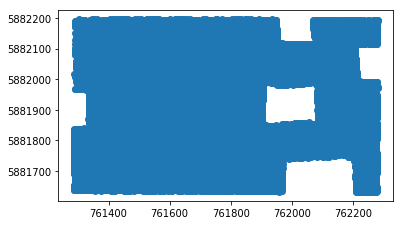

In [12]:
puntos.plot()

In [12]:
# puntos.to_file(driver = 'ESRI Shapefile', filename = "puntos_rotados")

In [13]:
coordenadas = []
csv = get_coordenadas(raster,puntos,url_salida,"pixeles")
# csv = pd.read_csv(url_salida+"pixeles.csv")
for element in range(csv.shape[0]):
    coordenadas.append([csv["y"][element],csv["x"][element]])

In [36]:
# coordenada

In [14]:
mapa_densidad = get_density_map_gaussian(coordenadas,raster.height,raster.width,sigma = 3)
# mapa_densidad = get_density_map_gaussian(coordenadas,raster.width,raster.height,sigma = 3)
# mapa_densidad=mapa_densidad.T

In [15]:
mapa_densidad.tofile(url_salida+"/mapa_densidad.txt")
# mapa_densidad = np.fromfile(url_salida+"mapa_densidad.txt")

In [16]:
raster.width,raster.height,mapa_densidad.shape

(13238, 7560, (7560, 13238))

In [24]:
# for i in range(mapa_densidad.shape[0]):
#     for j in range(mapa_densidad.shape[1]):
#         for p in range(4):
#             for q in range(4):
#                 print(i * 4 + p,j * 4 + q)
#                 mapa_densidad[i][j] += mapa_densidad[i * 4 + p][j * 4 + q]

(7560, 13238)


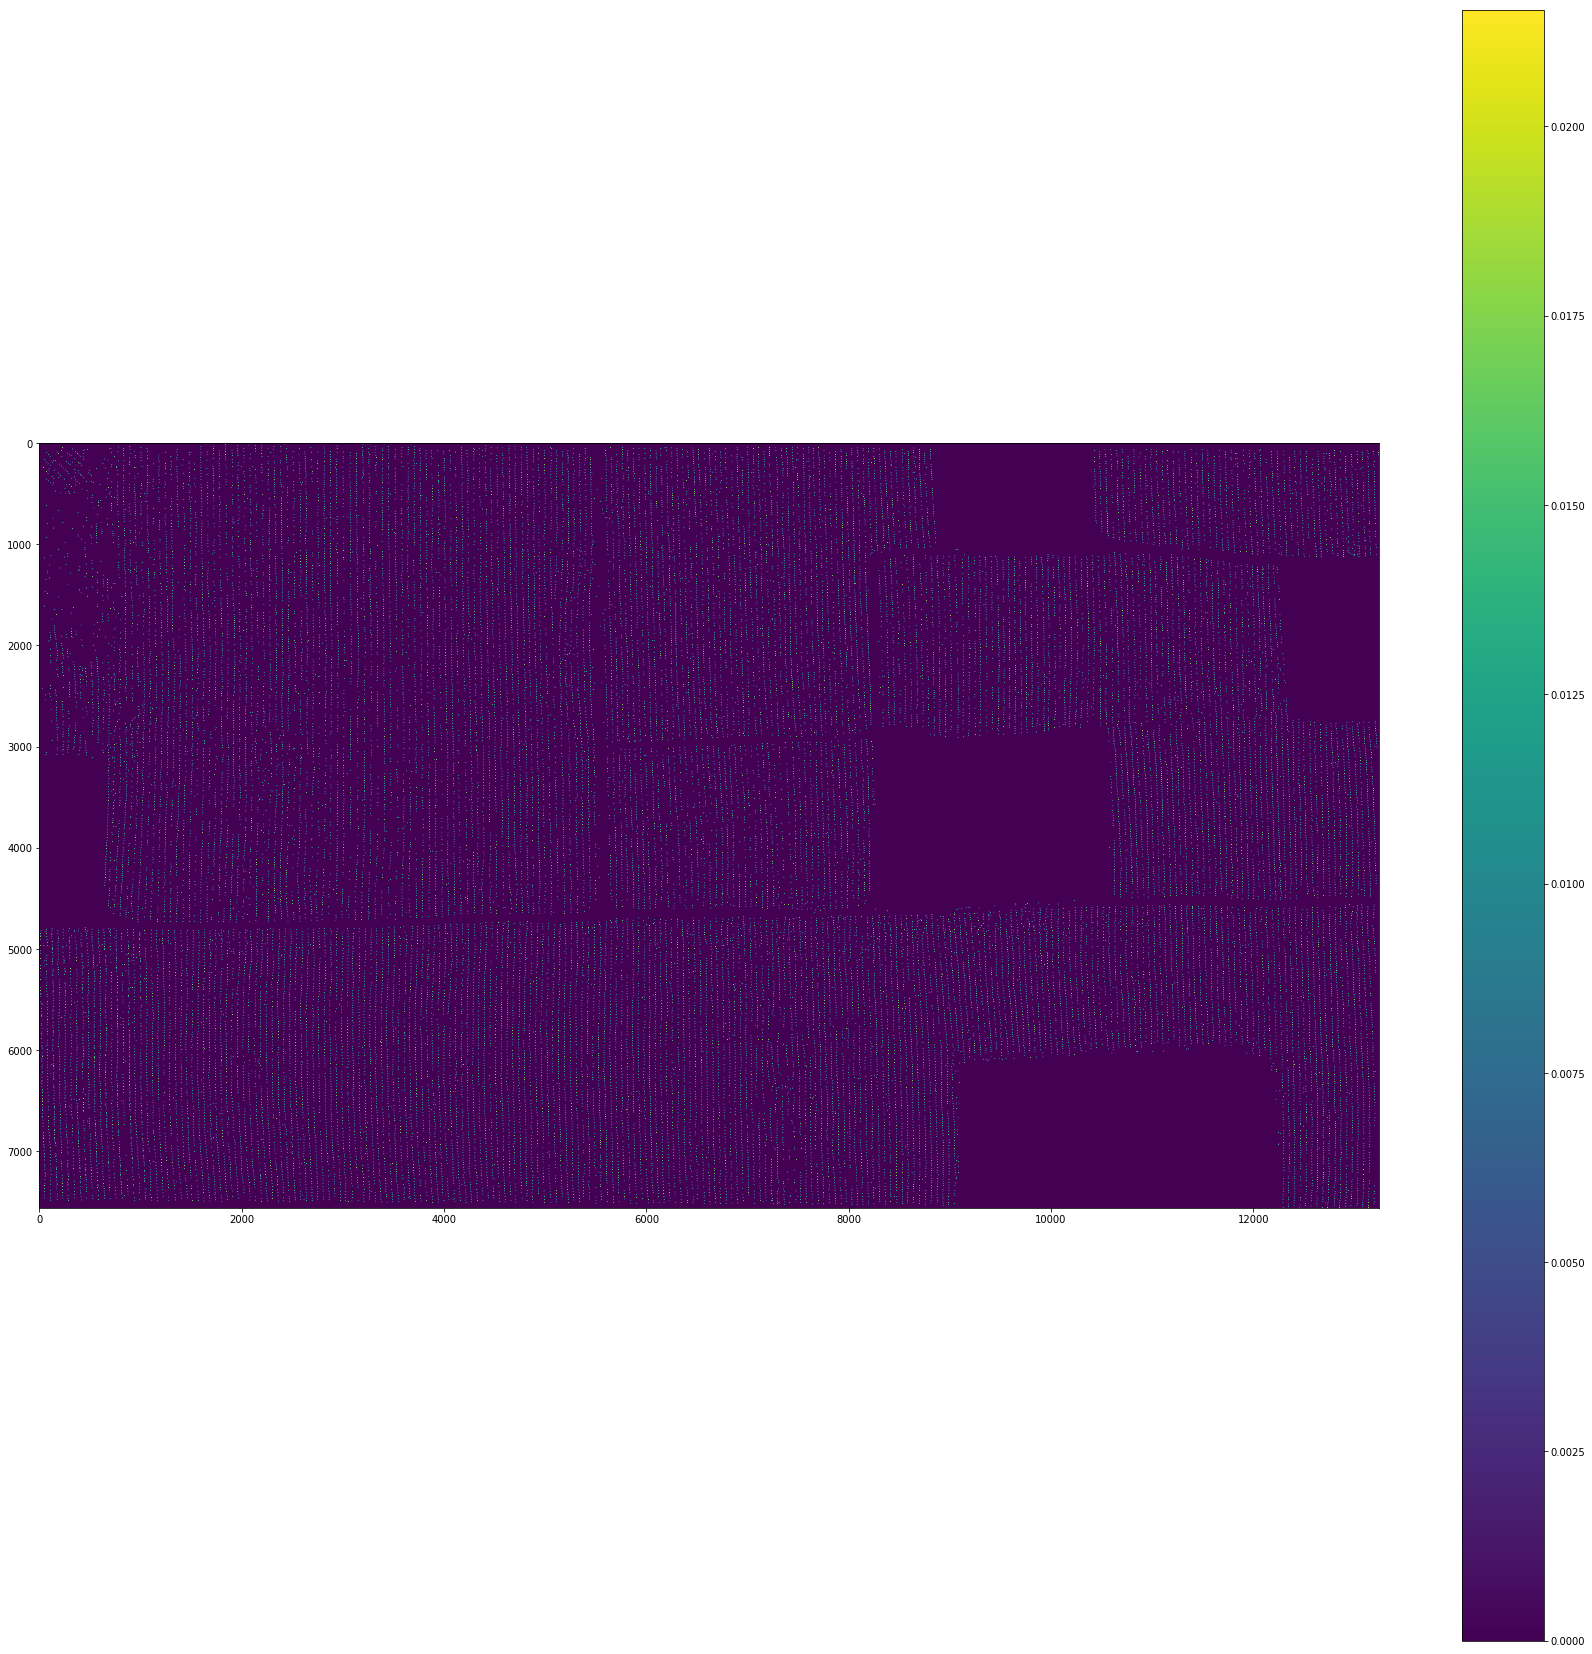

In [17]:
plt.figure(figsize=(30,30))
print(mapa_densidad.shape)
plt.imshow(mapa_densidad)
plt.colorbar()

plt.show()

In [18]:
unique, counts = np.unique(mapa_densidad, return_counts=True)
print(np.sum(mapa_densidad),puntos.shape[0])

44321.965 44322


In [17]:
# mapa_densidad.tofile()
# mapa_densidad = np.fromfile(url_salida+"/mapa_densidad.txt")

In [21]:
offsetX = 0
offsetY = 0
width = 100
height = 100
step = 100
nulo = [65535]
lista_imagenes = []
lista_etiquetas = []
lista_mapa = []
contador = 0

In [23]:
# %%time
contador = 0
out_meta = raster.meta.copy()
while (1):
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
   
    #entregamos los pixeles para obtener las coordenadas
#     t = raster.xy(offsetX, offsetY)
#     l = raster.xy(offsetX + width , offsetY)
#     r = raster.xy(offsetX, offsetY + height)
#     b = raster.xy(offsetX + width , offsetY + height)  
    t = raster.xy(offsetX, offsetY)
    r = raster.xy(offsetX + width , offsetY)
    l = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)
    minx = min(t[0],l[0],b[0],t[0])
    maxx = max(t[0],l[0],b[0],t[0])
    miny = min(t[1],l[1],b[1],t[1])
    maxy = max(t[1],l[1],b[1],t[1])
    bbox = box(minx, miny, maxx, maxy)  
    try:
        
#         print(contador)
        #transformacion de la imagen
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)
        valores = np.unique(out_img)

        # revisamos que no tenga valores mayores a 255 los reemplazamos por 0
        out_img[out_img > 255 ] = 0
      
    
        # quitamos pixeles irrelevantes   
     
        out_png = out_img[0:3,1:101,1:101]
#         out_img = out_img[:,1:101,0:100]

        if(out_png.shape != (3, 100, 100)):
            offsetX = offsetX + step
            continue
        
        out_meta.update({"driver": "GTiff",
                            "height": 100,
                            "width": 100,
                            "transform": out_transform,
                            "crs": raster.crs})
        
        #corte mapa densidad
        corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
        
#         interseccion ptos
        interseccion = puntos["geometry"].intersects(bbox)
        puntos_por_imagen = puntos[interseccion]
#         print("ejecuta")
#         puntos_por_imagen.to_file(url_salida_shp+"salida"+str(contador)+".shp")
        cantidad = interseccion.value_counts()

        
        if(True in cantidad.index):
#             print("ejecuta")
            numero = cantidad[True]
            mpimg.imsave('{}/salida{}.png'.format(url_salida_png,contador), out_png.T)
#             with rasterio.open('{}/salida{}.tif'.format(url_salida_tiff,contador), "w", **out_meta) as dest:
#                 dest.write(out_img)
            lista_imagenes.append(out_png.T)
            lista_mapa.append(corte.T)
            lista_etiquetas.append(numero)
            contador = contador + 1
        else:
            numero = 0
    except ValueError:
        pass
    offsetX = offsetX + step 

In [24]:
url_salida_shp

'D:/Memoria/Codigo Memoria/train/31/shp/'

In [25]:
len(lista_imagenes)

5560

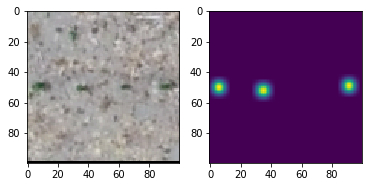

In [27]:
numero = 1200

flip = lista_mapa[numero]
# flip = np.rot90(np.flip(lista_mapa[numero],0),2)
plt.figure()
plt.subplot(121)
plt.imshow(lista_imagenes[numero])
plt.subplot(122)
plt.imshow(flip)
plt.show()

In [28]:
n_lista_imagenes = len(lista_imagenes)
n_lista_etiquetas = len(lista_etiquetas)
n_lista_mapa = len(lista_mapa)

In [1]:
# n_lista_imagenes,n_lista_mapa,lista_etiquetas

In [29]:
lista_imagenes = np.array(lista_imagenes)
lista_etiquetas = np.array(lista_etiquetas)
lista_mapa = np.array(lista_mapa)

In [30]:
HEIGHT = 100
WIDTH = 100
CHANNELS = 3
# hf = h5py.File(archivo_h5_cuentas, 'w')

In [ ]:
densidades = []
for element in target:
    den = element
    den_quarter = np.zeros((int(den.shape[0] / 4), int(den.shape[1] / 4)))
    for i in range(den_quarter.shape[0]):
        for j in range(den_quarter.shape[1]):
            for p in range(4):
                for q in range(4):
                    den_quarter[i][j] += den[i * 4 + p][j * 4 + q]
    den_quarter = den_quarter[:,:,None]
    densidades.append(den_quarter)

In [31]:
hf = h5py.File(archivo_h5_mapa, 'w')

In [32]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

Wall time: 1min 11s


In [33]:
%%time
Yset = hf.create_dataset(
        name= "density",
        data=lista_mapa,
        shape=(n_lista_mapa,HEIGHT,WIDTH),
        compression="gzip",
        compression_opts=9)


Wall time: 9.28 s


In [34]:
%%time
Zset = hf.create_dataset(
        name= "counts",
        data=lista_etiquetas,
        shape=(n_lista_mapa,),
        compression="gzip",
        compression_opts=9)


Wall time: 496 µs


In [ ]:
Vset = hf.create_dataset(
        name= "density_model",
        data=densidades,
        shape=(n_lista_mapa,HEIGHT/4,WIDTH/4),
        compression="gzip",
        compression_opts=9)

In [35]:
hf.close()

# Revision de los datos

In [ ]:
numero = 1521

with h5py.File('D:/Memoria/Codigo Memoria/train/29/data_mapa.h5', 'r') as hf:
    imagen = hf["images"][numero]
    densidad = hf["density"][numero]

In [133]:
imagen.shape,densidad.shape

((100, 100, 3), (100, 100))

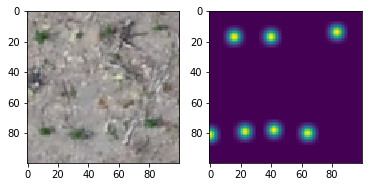

In [136]:
plt.figure()
plt.subplot(121)
plt.imshow(imagen)
plt.subplot(122)
plt.imshow(densidad)
plt.show()